# Specialist Weather Prediction Pipeline

## Overview
This notebook implements and compares different base learners for 3 prediction tasks: **Cold**, **Storm**, and **Heat** severe weather events. We use a **Binary Relevance** approach (one specialist model per event type) with **Expanding Window Temporal Cross-Validation**.


## Strategy: Specialist Models
Instead of one model for all events, we train independent "specialist" models:

| Model | Target | Why Separate? |
|-------|--------|---------------|
| Model A | Cold | Driven by temperature drops, pressure systems |
| Model B | Storm | Driven by pressure instability, wind patterns |
| Model C | Heat | Driven by extreme high temperatures, radiation |

## Validation: Expanding Window Temporal CV (4 Folds)

Tests: **"Does the model generalize to future time periods?"**

| Fold | Training Period | Validation Period |
|------|-----------------|-------------------|
| 1 | Jan 2019 – Dec 2019 | Jan – Mar 2020 |
| 2 | Jan 2019 – Mar 2020 | Apr – Jun 2020 |
| 3 | Jan 2019 – Jun 2020 | Jul – Sep 2020 |
| 4 | Jan 2019 – Sep 2020 | Oct – Dec 2020 |

This prevents **temporal leakage** and simulates real deployment (train on past, predict future).

## Models & Imbalance Handling

| Model | Imbalance Mechanism |
|-------|---------------------|
| Logistic Regression | `class_weight='balanced'` |
| Random Forest | `class_weight='balanced_subsample'` |
| XGBoost | `scale_pos_weight` (Neg/Pos ratio) |
| CatBoost | `auto_class_weights='Balanced'` |
| LSTM | `class_weight` dict (Neg/Pos ratio) |

## KPIs
- **ROC-AUC**: Ranking ability (1.0 = perfect, 0.5 = random)
- **Brier Score (MSE)**: Probability calibration (0.0 = perfect)

## Results

Our analysis demonstrates that tree-based models offer the optimal balance between computational efficiency and predictive performance. Consequently, we have selected XGBoost as our primary model for this project, as it delivers high accuracy while maintaining significantly faster training times compared to other ensembles.

## Section 1: Setup and Imports

We need the following packages:
- **pandas/numpy**: Data manipulation
- **scikit-learn**: Logistic Regression, Random Forest, preprocessing, metrics
- **xgboost**: Gradient boosting classifier
- **catboost**: Ordered gradient boosting with best probability calibration
- **tensorflow/keras**: LSTM (Long Short-Term Memory) deep learning model
- **matplotlib/seaborn**: Visualization
- **tqdm**: Progress bars for long training loops

In [1]:
# Core data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Deep Learning (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Preprocessing and metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, brier_score_loss

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bars
from tqdm import tqdm

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("All packages imported successfully!")

All packages imported successfully!


## Section 2: Load Data

We load the pre-processed dataset that contains:
- **Daily weather observations** for multiple cities/states
- **Weather features**: temperature, humidity, pressure, wind, precipitation, cloud cover
- **Event labels**: Which severe weather events occurred on each day

The data covers 2019-2020, which gives us enough temporal range for expanding window validation.

In [2]:
# Load the dataset
DATA_PATH = "final_processed_weather_data.csv"
df = pd.read_csv(DATA_PATH)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Display basic info
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Unique States: {df['State'].nunique()}")
print(f"Unique Cities: {df['City'].nunique()}")
print(f"\nStates in dataset: {sorted(df['State'].unique())}")

# Preview the data
df.head()

Dataset Shape: 252,616 rows × 51 columns
Date Range: 2019-01-04 to 2020-12-31
Unique States: 47
Unique Cities: 347

States in dataset: ['AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


,Date,City,State,Latitude,Longitude,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,rain_sum,...,temperature_2m_mean_rolling7_std,pressure_msl_mean_lag1,pressure_msl_mean_lag3,pressure_msl_mean_rolling7_mean,pressure_msl_mean_rolling7_std,relative_humidity_2m_mean_lag1,relative_humidity_2m_mean_lag3,relative_humidity_2m_mean_rolling7_mean,relative_humidity_2m_mean_rolling7_std,has_heat
0,2019-01-04,Aberdeen,MS,33.8738,-88.4897,12.1,7.2,9.4,16.2,16.2,...,1.707581,1018.4,1019.7,1017.575,5.987417,95.0,90.0,92.250000,2.061553,0
1,2019-01-05,Aberdeen,MS,33.8738,-88.4897,14.9,3.7,7.9,0.0,0.0,...,1.722498,1009.1,1023.1,1017.560,5.185364,92.0,92.0,89.600000,6.188699,0
2,2019-01-06,Aberdeen,MS,33.8738,-88.4897,16.5,2.5,8.5,0.0,0.0,...,1.591750,1017.5,1018.4,1018.350,5.025435,79.0,95.0,88.166667,6.554896,0
3,2019-01-07,Aberdeen,MS,33.8738,-88.4897,18.4,6.9,11.4,0.0,0.0,...,1.652703,1022.3,1009.1,1018.700,4.680100,81.0,92.0,86.714286,7.111359,0
4,2019-01-08,Aberdeen,MS,33.8738,-88.4897,19.6,13.6,16.0,1.4,1.4,...,2.815265,1020.8,1017.5,1018.700,4.680100,78.0,79.0,85.142857,7.470577,0


## Section 3: Create Binary Target Variables

The `Event_Types` column contains comma-separated event types (e.g., "Cold", "Cold, Storm"). 
We need to parse this into **separate binary columns** for each specialist model:

- `has_cold`: 1 if Cold event occurred, 0 otherwise
- `has_storm`: 1 if Storm event occurred, 0 otherwise
- `has_heat`: 1 if extreme Heat event occurred, 0 otherwise (pre-computed in dataset using dual-threshold logic — see Overview)

### Why Binary Relevance?
This approach treats each label independently. While it ignores potential correlations between events (e.g., storms often bring cold), it:
1. Allows specialized tuning per event type
2. Handles different imbalance ratios independently
3. Is simpler to interpret and debug

In [3]:
# Create binary target columns by checking if event type is in the Event_Types string
def create_binary_target(event_types_col, target_event):
    """
    Parse Event_Types column and create binary indicator for a specific event.
    
    Args:
        event_types_col: Series containing event type strings (e.g., "Cold", "Cold, Storm")
        target_event: The event to look for (e.g., "Cold")
    
    Returns:
        Binary series (1 if event present, 0 otherwise)
    """
    return event_types_col.fillna('').str.contains(target_event, case=False).astype(int)

# Create binary targets for Cold and Storm from Event_Types
df['has_cold'] = create_binary_target(df['Event_Types'], 'Cold')
df['has_storm'] = create_binary_target(df['Event_Types'], 'Storm')

# has_heat is already pre-computed in the dataset using a dual-threshold approach:
#   Absolute:  temperature_2m_max >= 35°C  (universally extreme)
#   Relative:  temperature_2m_max > city 95th-percentile AND > 28°C (locally unusual)
# A day is has_heat=1 if EITHER condition is met.
assert 'has_heat' in df.columns, "has_heat column not found in dataset!"

# Display class distribution for each target
print("=" * 60)
print("CLASS DISTRIBUTION (Imbalance Analysis)")
print("=" * 60)

targets = ['has_cold', 'has_storm', 'has_heat']
for target in targets:
    pos_count = df[target].sum()
    neg_count = len(df) - pos_count
    pos_pct = 100 * pos_count / len(df)
    imbalance_ratio = neg_count / pos_count if pos_count > 0 else float('inf')
    
    print(f"\n{target.upper().replace('HAS_', '')}:")
    print(f"  Positive (Event):     {pos_count:>6,} ({pos_pct:>5.2f}%)")
    print(f"  Negative (No Event):  {neg_count:>6,} ({100-pos_pct:>5.2f}%)")
    print(f"  Imbalance Ratio:      1:{imbalance_ratio:.1f}")

CLASS DISTRIBUTION (Imbalance Analysis)

COLD:
  Positive (Event):      8,069 ( 3.19%)
  Negative (No Event):  244,547 (96.81%)
  Imbalance Ratio:      1:30.3

STORM:
  Positive (Event):      1,901 ( 0.75%)
  Negative (No Event):  250,715 (99.25%)
  Imbalance Ratio:      1:131.9

HEAT:
  Positive (Event):     18,508 ( 7.33%)
  Negative (No Event):  234,108 (92.67%)
  Imbalance Ratio:      1:12.6


## Section 4: Feature Engineering (Advanced)

We engineer features at multiple levels to capture different aspects of weather patterns:

### 4.1 Base Features
Raw weather measurements from the dataset (temperature, humidity, pressure, wind, etc.)

### 4.2 Temporal Features
- **Month, Day of Year**: Capture seasonality (for example - storms more common in spring/summer)
- **Season**: Categorical encoding of meteorological seasons

### 4.3 Derived Features
- **Temperature Range**: Large daily swings may indicate instability
- **Pressure Range**: Rapid pressure changes often precede storms
- **Humidity Range**: Variability in moisture content

### 4.4 Lag Features
Previous day's values help capture **trends**. If pressure dropped yesterday, it might continue dropping.

### 4.5 Rolling Statistics
7-day rolling mean and standard deviation capture **recent weather patterns** and variability.

**Important**: Lag and rolling features must be computed **per location** (City) to avoid data leakage across different places.

In [4]:
# Define base feature columns (raw weather measurements)
BASE_FEATURES = [
    'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
    'relative_humidity_2m_max', 'relative_humidity_2m_min', 'relative_humidity_2m_mean',
    'pressure_msl_max', 'pressure_msl_min', 'pressure_msl_mean',
    'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant',
    'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours',
    'cloud_cover_mean', 'shortwave_radiation_sum'
]

# Verify all base features exist in the dataset
missing_features = [f for f in BASE_FEATURES if f not in df.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")
    BASE_FEATURES = [f for f in BASE_FEATURES if f in df.columns]

print(f"Using {len(BASE_FEATURES)} base features")
print(BASE_FEATURES)

Using 18 base features
['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'relative_humidity_2m_max', 'relative_humidity_2m_min', 'relative_humidity_2m_mean', 'pressure_msl_max', 'pressure_msl_min', 'pressure_msl_mean', 'wind_speed_10m_max', 'wind_gusts_10m_max', 'wind_direction_10m_dominant', 'precipitation_sum', 'rain_sum', 'snowfall_sum', 'precipitation_hours', 'cloud_cover_mean', 'shortwave_radiation_sum']


In [5]:
# ============================================================
# 4.2 TEMPORAL FEATURES
# ============================================================
# These capture seasonality - weather events have strong seasonal patterns

# Month (1-12): Captures monthly patterns
df['month'] = df['Date'].dt.month

# Day of year (1-365): Captures finer seasonal patterns
df['day_of_year'] = df['Date'].dt.dayofyear

# Season: Meteorological seasons
# Winter: Dec, Jan, Feb (12, 1, 2)
# Spring: Mar, Apr, May (3, 4, 5)
# Summer: Jun, Jul, Aug (6, 7, 8)
# Fall: Sep, Oct, Nov (9, 10, 11)
def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

df['season'] = df['month'].apply(get_season)

TEMPORAL_FEATURES = ['month', 'day_of_year', 'season']
print(f"Created {len(TEMPORAL_FEATURES)} temporal features: {TEMPORAL_FEATURES}")

Created 3 temporal features: ['month', 'day_of_year', 'season']


In [6]:
# ============================================================
# 4.3 DERIVED FEATURES
# ============================================================
# These capture daily variability which can indicate weather instability

# Temperature range: Large swings may indicate frontal passages
df['temp_range'] = df['temperature_2m_max'] - df['temperature_2m_min']

# Pressure range: Rapid changes often precede severe weather
df['pressure_range'] = df['pressure_msl_max'] - df['pressure_msl_min']

# Humidity range: Variability in moisture
df['humidity_range'] = df['relative_humidity_2m_max'] - df['relative_humidity_2m_min']

DERIVED_FEATURES = ['temp_range', 'pressure_range', 'humidity_range']
print(f"Created {len(DERIVED_FEATURES)} derived features: {DERIVED_FEATURES}")

Created 3 derived features: ['temp_range', 'pressure_range', 'humidity_range']


In [7]:
# ============================================================
# 4.4 & 4.5 LAG AND ROLLING FEATURES
# ============================================================
# CRITICAL: Must be computed per City to avoid spatial data leakage!
# We sort by Date within each City before computing lags/rolling.

# Features to create lags and rolling stats for
KEY_FEATURES = ['temperature_2m_mean', 'pressure_msl_mean', 'relative_humidity_2m_mean']

# Sort data by City and Date (required for proper lag/rolling computation)
df = df.sort_values(['City', 'Date']).reset_index(drop=True)

LAG_FEATURES = []
ROLLING_FEATURES = []

print("Computing lag and rolling features per city...")

for feature in tqdm(KEY_FEATURES, desc="Processing features"):
    # --- LAG FEATURES ---
    # Lag 1: Previous day's value
    lag1_name = f'{feature}_lag1'
    df[lag1_name] = df.groupby('City')[feature].shift(1)
    LAG_FEATURES.append(lag1_name)
    
    # Lag 3: Value from 3 days ago (captures short-term trends)
    lag3_name = f'{feature}_lag3'
    df[lag3_name] = df.groupby('City')[feature].shift(3)
    LAG_FEATURES.append(lag3_name)
    
    # --- ROLLING FEATURES ---
    # 7-day rolling mean: Recent average conditions
    roll_mean_name = f'{feature}_rolling7_mean'
    df[roll_mean_name] = df.groupby('City')[feature].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    ROLLING_FEATURES.append(roll_mean_name)
    
    # 7-day rolling std: Recent variability
    roll_std_name = f'{feature}_rolling7_std'
    df[roll_std_name] = df.groupby('City')[feature].transform(
        lambda x: x.rolling(window=7, min_periods=1).std()
    )
    ROLLING_FEATURES.append(roll_std_name)

print(f"\nCreated {len(LAG_FEATURES)} lag features: {LAG_FEATURES}")
print(f"Created {len(ROLLING_FEATURES)} rolling features: {ROLLING_FEATURES}")

Computing lag and rolling features per city...



Processing features:   0%|          | 0/3 [00:00<?, ?it/s]


Processing features:  33%|███▎      | 1/3 [00:00<00:01,  1.67it/s]


Processing features:  67%|██████▋   | 2/3 [00:01<00:00,  1.23it/s]


Processing features: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


Processing features: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


Created 6 lag features: ['temperature_2m_mean_lag1', 'temperature_2m_mean_lag3', 'pressure_msl_mean_lag1', 'pressure_msl_mean_lag3', 'relative_humidity_2m_mean_lag1', 'relative_humidity_2m_mean_lag3']
Created 6 rolling features: ['temperature_2m_mean_rolling7_mean', 'temperature_2m_mean_rolling7_std', 'pressure_msl_mean_rolling7_mean', 'pressure_msl_mean_rolling7_std', 'relative_humidity_2m_mean_rolling7_mean', 'relative_humidity_2m_mean_rolling7_std']


In [8]:
# ============================================================
# COMBINE ALL FEATURES AND HANDLE MISSING VALUES
# ============================================================

# Combine all feature lists
ALL_FEATURES = BASE_FEATURES + TEMPORAL_FEATURES + DERIVED_FEATURES + LAG_FEATURES + ROLLING_FEATURES

print(f"Total features: {len(ALL_FEATURES)}")
print(f"  - Base features: {len(BASE_FEATURES)}")
print(f"  - Temporal features: {len(TEMPORAL_FEATURES)}")
print(f"  - Derived features: {len(DERIVED_FEATURES)}")
print(f"  - Lag features: {len(LAG_FEATURES)}")
print(f"  - Rolling features: {len(ROLLING_FEATURES)}")

# Check for missing values
rows_before = len(df)
missing_rows = df[ALL_FEATURES].isnull().any(axis=1).sum()
print(f"\nRows with missing values: {missing_rows:,} ({100*missing_rows/rows_before:.2f}%)")

# Why we DROP instead of impute:
# - Missing values only occur in first ~3 days per city (lag/rolling features)
# - These rows lack meaningful historical context anyway
# - Dropping is cleaner than imputing artificial values
# - Data loss is minimal (~3 days × n_cities)

df = df.dropna(subset=ALL_FEATURES).reset_index(drop=True)

rows_after = len(df)
print(f"Rows dropped: {rows_before - rows_after:,}")
print(f"Rows remaining: {rows_after:,} ({100*rows_after/rows_before:.2f}%)")

Total features: 36
  - Base features: 18
  - Temporal features: 3
  - Derived features: 3
  - Lag features: 6
  - Rolling features: 6

Rows with missing values: 1,041 (0.41%)


Rows dropped: 1,041
Rows remaining: 251,575 (99.59%)


## Section 5: Cross-Validation Framework

We implement **Expanding Window Temporal Cross-Validation** to test time-series generalization:

### Expanding Window (4 folds)
- **Goal**: Test if model generalizes to **future time periods**
- **Method**: Train on historical data, validate on future quarters with expanding training window
- **Why**: Weather prediction must work on future dates, not just historical ones

This prevents **temporal leakage** and answers: **"Will this model work on next quarter's data?"**

In [9]:
# ============================================================
# EXPANDING WINDOW TEMPORAL SPLITTER
# ============================================================
# Implements time-series cross-validation with expanding training window.
# Training window grows over time, validation is always the next quarter.

class ExpandingWindowSplit:
    """
    Temporal cross-validator using expanding training windows.
    
    This mimics real-world deployment: train on all historical data,
    predict future periods. The training set grows with each fold.
    """
    
    def __init__(self):
        # Define the temporal folds
        # Format: (train_end_date, val_start_date, val_end_date)
        self.folds = [
            ('2019-12-31', '2020-01-01', '2020-03-31'),  # Fold 1: Full 2019 → Q1 2020
            ('2020-03-31', '2020-04-01', '2020-06-30'),  # Fold 2: +Q1 2020 → Q2 2020
            ('2020-06-30', '2020-07-01', '2020-09-30'),  # Fold 3: +Q2 2020 → Q3 2020
            ('2020-09-30', '2020-10-01', '2020-12-31'),  # Fold 4: +Q3 2020 → Q4 2020
        ]
        # Training always starts from the beginning of the dataset
        self.train_start = '2019-01-01'
    
    def split(self, df, date_col='Date'):
        """
        Generate indices for expanding window splits.
        
        Args:
            df: DataFrame with data
            date_col: Name of the date column
        
        Yields:
            train_idx, val_idx: Arrays of indices
        """
        dates = pd.to_datetime(df[date_col])
        
        for train_end, val_start, val_end in self.folds:
            train_end = pd.to_datetime(train_end)
            val_start = pd.to_datetime(val_start)
            val_end = pd.to_datetime(val_end)
            
            # Training: all data from start up to train_end
            train_mask = (dates >= self.train_start) & (dates <= train_end)
            
            # Validation: data in the validation window
            val_mask = (dates >= val_start) & (dates <= val_end)
            
            train_idx = np.where(train_mask)[0]
            val_idx = np.where(val_mask)[0]
            
            # Only yield if both sets have data
            if len(train_idx) > 0 and len(val_idx) > 0:
                yield train_idx, val_idx
    
    def get_n_splits(self):
        return len(self.folds)

# Create the temporal CV splitter
temporal_cv = ExpandingWindowSplit()

print("Expanding Window Temporal CV Configuration:")
print(f"  Number of folds: {temporal_cv.get_n_splits()}")
print(f"\nFold details:")
for i, (train_end, val_start, val_end) in enumerate(temporal_cv.folds, 1):
    print(f"  Fold {i}: Train until {train_end} → Validate {val_start} to {val_end}")

Expanding Window Temporal CV Configuration:
  Number of folds: 4

Fold details:
  Fold 1: Train until 2019-12-31 → Validate 2020-01-01 to 2020-03-31
  Fold 2: Train until 2020-03-31 → Validate 2020-04-01 to 2020-06-30
  Fold 3: Train until 2020-06-30 → Validate 2020-07-01 to 2020-09-30
  Fold 4: Train until 2020-09-30 → Validate 2020-10-01 to 2020-12-31


In [10]:
# Cell removed - ExpandingWindowSplit is now in the cell above

## Section 6: Model Definitions

We compare **5 model architectures**, each with built-in handling for class imbalance:

| Model | Type | Imbalance Handling |
|-------|------|-------------------|
| **Logistic Regression** | Linear | `class_weight='balanced'` - Upweights minority class |
| **Random Forest** | Bagging (Trees) | `class_weight='balanced_subsample'` - Rebalances per bootstrap |
| **XGBoost** | Boosting (Trees) | `scale_pos_weight` - Upweights positive class gradient |
| **CatBoost** | Boosting (Trees) | `auto_class_weights='Balanced'` - Automatic balancing |
| **LSTM** | Deep Learning (RNN) | `class_weight` dict - Upweights positive class during training |

### Why These Models?
- **Logistic Regression**: Simple, interpretable baseline. Tests if linear patterns are sufficient.
- **Random Forest**: Bagging approach - averages many independent trees. Robust to outliers.
- **XGBoost**: Gradient boosting - sequential trees that correct errors. Fast and popular.
- **CatBoost**: Ordered boosting - prevents target leakage. **Best probability calibration**.
- **LSTM (Long Short-Term Memory)**: A type of recurrent neural network (RNN) that uses gating mechanisms (input, forget, output gates) to selectively retain or discard information over time. Although the features already include lag and rolling statistics, the LSTM can learn additional non-linear temporal dependencies directly from the scaled feature vector.

In [11]:
# ============================================================
# LSTM WRAPPER (sklearn-compatible interface)
# ============================================================
# Wraps a Keras LSTM model so it can be used in the same
# training loop as the sklearn / boosting models.

class LSTMClassifier:
    """
    LSTM classifier with sklearn-like fit / predict_proba API.
    
    Each sample is reshaped into a single-step sequence
    (timesteps=1, features=n_features). This lets the LSTM
    act as a non-linear classifier while keeping the same
    cross-validation framework as the other models.
    """
    
    def __init__(self, n_features, n_positive=1, n_negative=1,
                 epochs=20, batch_size=512, random_state=42):
        self.n_features = n_features
        self.epochs = epochs
        self.batch_size = batch_size
        self.random_state = random_state
        self.n_positive = n_positive
        self.n_negative = n_negative
        self.model = None
    
    def _build_model(self):
        tf.random.set_seed(self.random_state)
        model = Sequential([
            LSTM(64, input_shape=(1, self.n_features), return_sequences=True),
            Dropout(0.3),
            LSTM(32),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model
    
    def fit(self, X, y, **kwargs):
        np.random.seed(self.random_state)
        tf.random.set_seed(self.random_state)
        
        # Reshape: (samples, 1 timestep, features)
        X_seq = X.reshape(X.shape[0], 1, X.shape[1])
        
        # Class weights for imbalance handling
        class_weight = {
            0: 1.0,
            1: self.n_negative / self.n_positive if self.n_positive > 0 else 1.0
        }
        
        self.model = self._build_model()
        self.model.fit(
            X_seq, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            class_weight=class_weight,
            verbose=0,
            callbacks=[EarlyStopping(patience=5,
                                     restore_best_weights=True,
                                     monitor='loss')],
            validation_split=0.1
        )
        return self
    
    def predict_proba(self, X):
        X_seq = X.reshape(X.shape[0], 1, X.shape[1])
        pos_proba = self.model.predict(X_seq, verbose=0).flatten()
        return np.column_stack([1 - pos_proba, pos_proba])


# ============================================================
# MODEL FACTORY
# ============================================================
# Creates fresh model instances with appropriate imbalance handling.

def create_models(n_positive, n_negative, n_features=None):
    """
    Create dictionary of models with imbalance-aware configurations.
    
    Args:
        n_positive: Number of positive samples in training set
        n_negative: Number of negative samples in training set
        n_features: Number of input features (needed for LSTM)
    
    Returns:
        Dictionary of model name → model instance
    """
    # Calculate imbalance ratio for XGBoost
    scale_pos_weight = n_negative / n_positive if n_positive > 0 else 1.0
    
    models = {
        'Logistic_Regression': LogisticRegression(
            class_weight='balanced',  # Auto-balances based on class frequency
            max_iter=1000,
            random_state=RANDOM_STATE,
            solver='lbfgs'
        ),
        
        'Random_Forest': RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced_subsample',  # Balance per bootstrap sample
            max_depth=10,
            random_state=RANDOM_STATE,
            n_jobs=-1  # Use all CPU cores
        ),
        
        'XGBoost': XGBClassifier(
            n_estimators=100,
            scale_pos_weight=scale_pos_weight,  # Upweight positive class
            max_depth=6,
            learning_rate=0.1,
            random_state=RANDOM_STATE,
            use_label_encoder=False,
            eval_metric='logloss',
            verbosity=0
        ),
        
        'CatBoost': CatBoostClassifier(
            iterations=100,
            auto_class_weights='Balanced',  # Automatic class balancing
            depth=6,
            learning_rate=0.1,
            random_state=RANDOM_STATE,
            verbose=0  # Silent mode
        ),
        
        'LSTM': LSTMClassifier(
            n_features=n_features if n_features else 36,
            n_positive=n_positive,
            n_negative=n_negative,
            epochs=20,
            batch_size=512,
            random_state=RANDOM_STATE
        )
    }
    
    return models

print("Model factory defined!")
print("Models: Logistic Regression, Random Forest, XGBoost, CatBoost, LSTM")

Model factory defined!
Models: Logistic Regression, Random Forest, XGBoost, CatBoost, LSTM


## Section 7: Main Training Loop

We use **Expanding Window Temporal Cross-Validation** (4 folds):

- Train on historical data, validate on future quarters
- Each fold: Training window expands, validation window slides forward
- This tests: **"Does the model generalize to future time periods?"**

```
For each EVENT TYPE (Cold, Storm, Heat):
    For each TEMPORAL FOLD (4 folds):
        Train on all data up to train_end_date
        Validate on next quarter (val_start to val_end)
        Record AUC and Brier Score
```

### Metrics
- **ROC-AUC**: Ranking ability (1.0 = perfect, 0.5 = random)
- **Brier Score (MSE)**: Probability calibration (0.0 = perfect)

In [12]:
# Cell moved to Section 9: Visualization (after heatmap)
# See below for ROC curves visualization

In [13]:
# ============================================================
# MAIN TRAINING LOOP - TEMPORAL CROSS-VALIDATION
# ============================================================

# Store results
results = []

# Store predictions for last fold (for ROC curves)
last_fold_predictions = {}  # {target: {model: (y_true, y_pred)}}

# Target columns for specialist models
TARGET_COLS = ['has_cold', 'has_storm', 'has_heat']

# Feature dimension
input_dim = len(ALL_FEATURES)

# Get last fold index
last_fold_num = temporal_cv.get_n_splits()

print("=" * 70)
print("STARTING TEMPORAL CROSS-VALIDATION")
print("=" * 70)
print(f"Features: {input_dim}")
print(f"Targets: {TARGET_COLS}")
print(f"Total samples: {len(df):,}")
print(f"Temporal folds: {temporal_cv.get_n_splits()}")
print("=" * 70)

# Loop through each specialist target
for target_col in TARGET_COLS:
    target_name = target_col.replace('has_', '').upper()
    print(f"\n{'='*70}")
    print(f"TRAINING SPECIALIST MODEL: {target_name}")
    print(f"{'='*70}")
    
    # Initialize storage for this target's last fold predictions
    last_fold_predictions[target_name] = {}
    
    # Temporal cross-validation (expanding window)
    for fold_idx, (train_idx, val_idx) in enumerate(temporal_cv.split(df)):
        # Get the date ranges for this fold
        train_end, val_start, val_end = temporal_cv.folds[fold_idx]
        
        print(f"\n  Fold {fold_idx + 1}/{temporal_cv.get_n_splits()}")
        print(f"    Train: until {train_end}, {len(train_idx):,} samples")
        print(f"    Validate: {val_start} to {val_end}, {len(val_idx):,} samples")
        
        # Extract features and labels
        X_train = df.iloc[train_idx][ALL_FEATURES].values
        y_train = df.iloc[train_idx][target_col].values
        X_val = df.iloc[val_idx][ALL_FEATURES].values
        y_val = df.iloc[val_idx][target_col].values
        
        # Skip if not enough positive samples
        if y_train.sum() < 5 or y_val.sum() < 2:
            print(f"    ⚠ Skipped: insufficient positive samples")
            continue
        
        # Scale features (fit on training data only!)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Get imbalance info for model configuration
        n_positive = int(y_train.sum())
        n_negative = len(y_train) - n_positive
        
        # Create and train models
        models = create_models(n_positive, n_negative, n_features=input_dim)
        
        # Check if this is the last fold
        is_last_fold = (fold_idx + 1) == last_fold_num
        
        for model_name, model in models.items():
            try:
                # All models now use the same interface
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict_proba(X_val_scaled)[:, 1]
                
                # Calculate metrics
                auc = roc_auc_score(y_val, y_pred)
                brier = brier_score_loss(y_val, y_pred)
                
                # Store results
                results.append({
                    'target': target_name,
                    'model': model_name,
                    'fold': fold_idx + 1,
                    'val_period': f"{val_start} to {val_end}",
                    'auc': auc,
                    'brier_score': brier,
                    'n_train': len(y_train),
                    'n_val': len(y_val),
                    'pos_rate_train': y_train.mean(),
                    'pos_rate_val': y_val.mean()
                })
                
                # Store predictions for last fold (for ROC curves)
                if is_last_fold:
                    last_fold_predictions[target_name][model_name] = (y_val, y_pred)
                
            except Exception as e:
                print(f"      ⚠ {model_name}: {str(e)[:40]}")
        
        print(f"    ✓ Complete")

print("\n" + "=" * 70)
print("TRAINING COMPLETE!")
print(f"Total results: {len(results)}")
print(f"Last fold predictions stored for ROC curves")
print("=" * 70)

STARTING TEMPORAL CROSS-VALIDATION
Features: 36
Targets: ['has_cold', 'has_storm', 'has_heat']
Total samples: 251,575
Temporal folds: 4

TRAINING SPECIALIST MODEL: COLD

  Fold 1/4
    Train: until 2019-12-31, 124,573 samples
    Validate: 2020-01-01 to 2020-03-31, 31,577 samples


    ✓ Complete

  Fold 2/4
    Train: until 2020-03-31, 156,150 samples
    Validate: 2020-04-01 to 2020-06-30, 31,577 samples


    ✓ Complete

  Fold 3/4
    Train: until 2020-06-30, 187,727 samples
    Validate: 2020-07-01 to 2020-09-30, 31,924 samples


    ✓ Complete

  Fold 4/4
    Train: until 2020-09-30, 219,651 samples
    Validate: 2020-10-01 to 2020-12-31, 31,924 samples


    ✓ Complete

TRAINING SPECIALIST MODEL: STORM

  Fold 1/4
    Train: until 2019-12-31, 124,573 samples
    Validate: 2020-01-01 to 2020-03-31, 31,577 samples


    ✓ Complete

  Fold 2/4
    Train: until 2020-03-31, 156,150 samples
    Validate: 2020-04-01 to 2020-06-30, 31,577 samples


    ✓ Complete

  Fold 3/4
    Train: until 2020-06-30, 187,727 samples
    Validate: 2020-07-01 to 2020-09-30, 31,924 samples


    ✓ Complete

  Fold 4/4
    Train: until 2020-09-30, 219,651 samples
    Validate: 2020-10-01 to 2020-12-31, 31,924 samples


    ✓ Complete

TRAINING SPECIALIST MODEL: HEAT

  Fold 1/4
    Train: until 2019-12-31, 124,573 samples
    Validate: 2020-01-01 to 2020-03-31, 31,577 samples


    ✓ Complete

  Fold 2/4
    Train: until 2020-03-31, 156,150 samples
    Validate: 2020-04-01 to 2020-06-30, 31,577 samples


    ✓ Complete

  Fold 3/4
    Train: until 2020-06-30, 187,727 samples
    Validate: 2020-07-01 to 2020-09-30, 31,924 samples


    ✓ Complete

  Fold 4/4
    Train: until 2020-09-30, 219,651 samples
    Validate: 2020-10-01 to 2020-12-31, 31,924 samples


    ✓ Complete

TRAINING COMPLETE!
Total results: 60
Last fold predictions stored for ROC curves


## Section 8: Results Aggregation and Analysis

Now we aggregate results across all 4 temporal folds to get robust performance estimates:

- **Mean Score**: Average performance across all validation quarters (Q1-Q4 2020)
- **Standard Deviation**: Variability in performance across different time periods

We report:
- **ROC-AUC**: Ranking ability (higher is better)
- **Brier Score / MSE**: Probability calibration (lower is better)

In [14]:
# ============================================================
# CONVERT RESULTS TO DATAFRAME
# ============================================================

results_df = pd.DataFrame(results)

print("TEMPORAL CROSS-VALIDATION RESULTS")
print(f"  Shape: {results_df.shape}")
print(f"  Evaluates: Model performance on future time periods (temporal generalization)")
print(f"\nResults per target: {results_df.groupby('target').size().to_dict()}")

results_df.head(10)

TEMPORAL CROSS-VALIDATION RESULTS
  Shape: (60, 10)
  Evaluates: Model performance on future time periods (temporal generalization)

Results per target: {'COLD': 20, 'HEAT': 20, 'STORM': 20}


,target,model,fold,val_period,auc,brier_score,n_train,n_val,pos_rate_train,pos_rate_val
0,COLD,Logistic_Regression,1,2020-01-01 to 2020-03-31,0.658844,0.283950,124573,31577,0.033924,0.03455
1,COLD,Random_Forest,1,2020-01-01 to 2020-03-31,0.670592,0.137861,124573,31577,0.033924,0.03455
2,COLD,XGBoost,1,2020-01-01 to 2020-03-31,0.669730,0.169043,124573,31577,0.033924,0.03455
3,COLD,CatBoost,1,2020-01-01 to 2020-03-31,0.667905,0.208535,124573,31577,0.033924,0.03455
4,COLD,LSTM,1,2020-01-01 to 2020-03-31,0.678224,0.222103,124573,31577,0.033924,0.03455
5,COLD,Logistic_Regression,2,2020-04-01 to 2020-06-30,0.506811,0.180803,156150,31577,0.034051,0.03056
6,COLD,Random_Forest,2,2020-04-01 to 2020-06-30,0.552303,0.125072,156150,31577,0.034051,0.03056
7,COLD,XGBoost,2,2020-04-01 to 2020-06-30,0.536367,0.119437,156150,31577,0.034051,0.03056
8,COLD,CatBoost,2,2020-04-01 to 2020-06-30,0.559858,0.138228,156150,31577,0.034051,0.03056
9,COLD,LSTM,2,2020-04-01 to 2020-06-30,0.575000,0.146258,156150,31577,0.034051,0.03056


In [15]:
# ============================================================
# AGGREGATE RESULTS BY TARGET AND MODEL
# ============================================================

# Calculate mean and std across all folds
summary_df = results_df.groupby(['target', 'model']).agg({
    'auc': ['mean', 'std'],
    'brier_score': ['mean', 'std']
}).round(4)

# Flatten column names
summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns.values]
summary_df = summary_df.reset_index()

# Display results
print("=" * 80)
print("TEMPORAL CROSS-VALIDATION: MEAN PERFORMANCE ACROSS FOLDS")
print("=" * 80)
print("\nMetrics (evaluated on future time periods):")
print("  - AUC: Higher is better (1.0 = perfect, 0.5 = random)")
print("  - Brier: Lower is better (0.0 = perfect)")
print("=" * 80)

for target in ['COLD', 'STORM', 'HEAT']:
    print(f"\n{'-'*60}")
    print(f"TARGET: {target}")
    print(f"{'-'*60}")
    print(f"{'Model':<22} | {'AUC':^20} | {'Brier Score':^16}")
    print("-" * 60)
    
    target_data = summary_df[summary_df['target'] == target].sort_values('auc_mean', ascending=False)
    
    for _, row in target_data.iterrows():
        auc_str = f"{row['auc_mean']:.3f} ± {row['auc_std']:.3f}"
        brier_str = f"{row['brier_score_mean']:.4f} ± {row['brier_score_std']:.4f}"
        print(f"{row['model']:<22} | {auc_str:^20} | {brier_str:^16}")

TEMPORAL CROSS-VALIDATION: MEAN PERFORMANCE ACROSS FOLDS

Metrics (evaluated on future time periods):
  - AUC: Higher is better (1.0 = perfect, 0.5 = random)
  - Brier: Lower is better (0.0 = perfect)

------------------------------------------------------------
TARGET: COLD
------------------------------------------------------------
Model                  |         AUC          |   Brier Score   
------------------------------------------------------------
LSTM                   |    0.597 ± 0.056     | 0.1851 ± 0.0312 
CatBoost               |    0.589 ± 0.054     | 0.1692 ± 0.0300 
Random_Forest          |    0.582 ± 0.059     | 0.1425 ± 0.0165 
XGBoost                |    0.577 ± 0.062     | 0.1447 ± 0.0204 
Logistic_Regression    |    0.563 ± 0.066     | 0.2159 ± 0.0500 

------------------------------------------------------------
TARGET: STORM
------------------------------------------------------------
Model                  |         AUC          |   Brier Score   
----------

## Section 9: Visualization

Visual comparison of model performance across all targets and metrics.

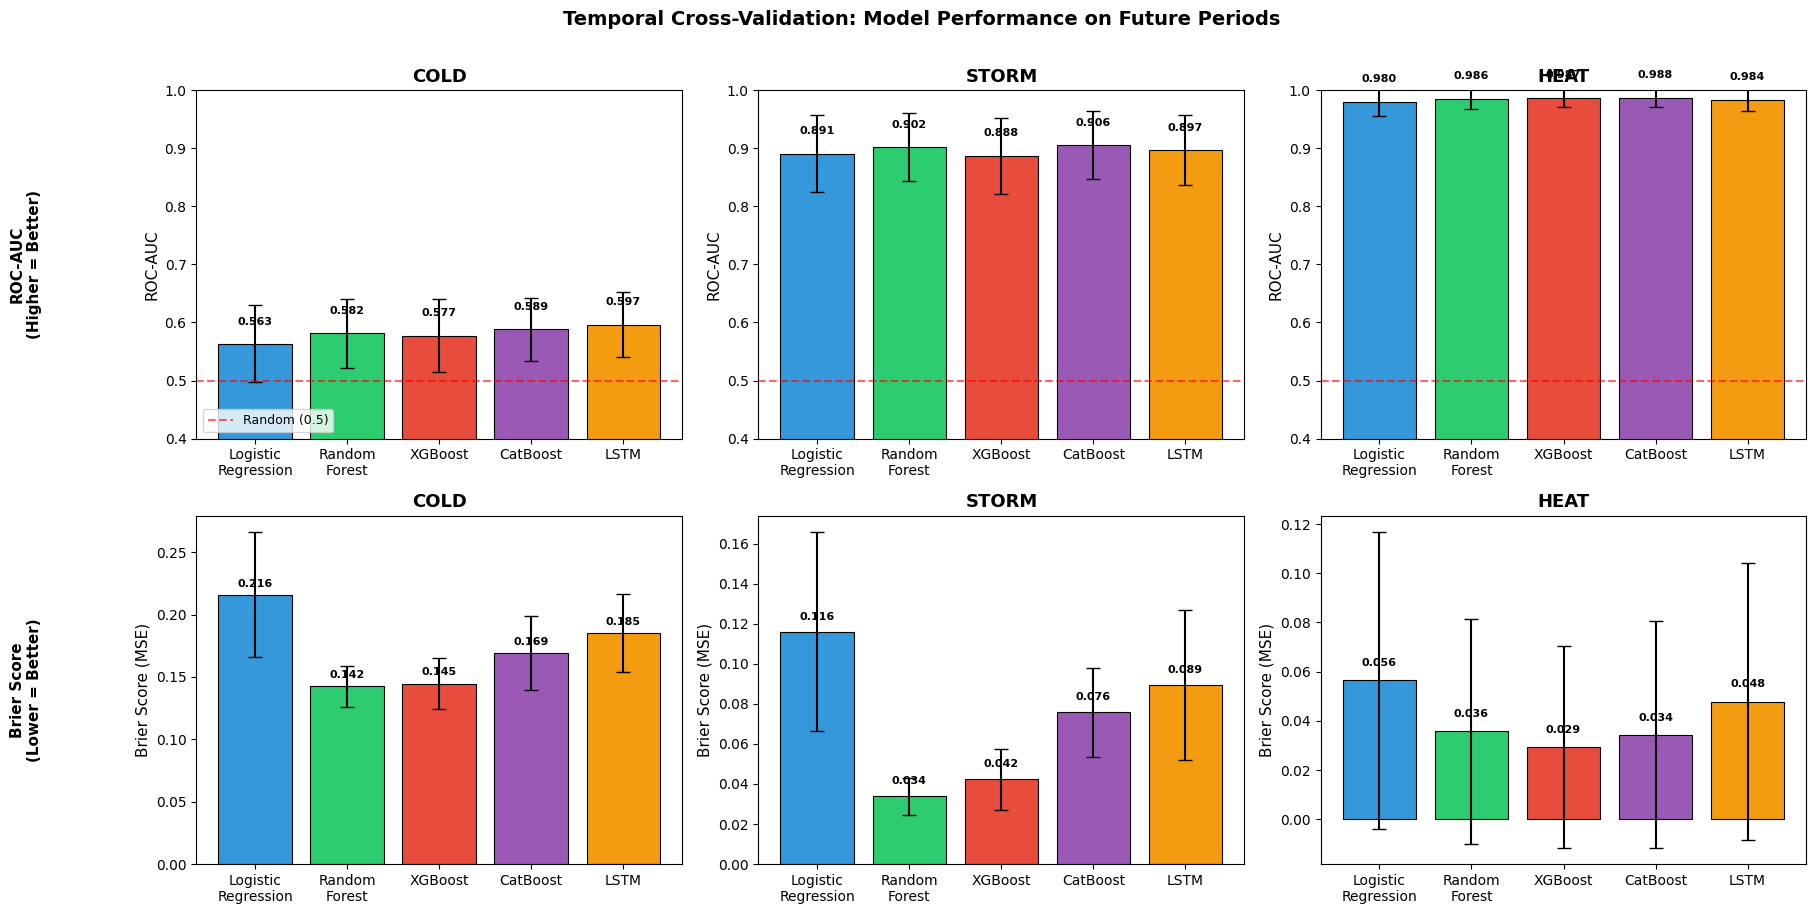


Plot saved as 'temporal_cv_model_comparison.png'


In [16]:
# ============================================================
# VISUALIZATION: MODEL COMPARISON BY TARGET
# ============================================================

targets = ['COLD', 'STORM', 'HEAT']
models = ['Logistic_Regression', 'Random_Forest', 'XGBoost', 'CatBoost', 'LSTM']
model_labels = ['Logistic\nRegression', 'Random\nForest', 'XGBoost', 'CatBoost', 'LSTM']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

fig, axes = plt.subplots(2, len(targets), figsize=(6 * len(targets), 9))

for col, target in enumerate(targets):
    target_data = summary_df[summary_df['target'] == target].set_index('model')
    
    # --- ROC-AUC ---
    ax = axes[0, col]
    auc_vals = [target_data.loc[m, 'auc_mean'] if m in target_data.index else 0 for m in models]
    auc_stds = [target_data.loc[m, 'auc_std'] if m in target_data.index else 0 for m in models]
    
    bars = ax.bar(model_labels, auc_vals, yerr=auc_stds, capsize=5, 
                  color=colors, edgecolor='black', linewidth=0.8)
    
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.6, linewidth=1.5, label='Random (0.5)')
    ax.set_ylabel('ROC-AUC', fontsize=11)
    ax.set_title(f'{target}', fontsize=13, fontweight='bold')
    ax.set_ylim(0.4, 1.0)
    
    # Value labels
    for bar, val in zip(bars, auc_vals):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, 
                    f'{val:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    if col == 0:
        ax.legend(loc='lower left', fontsize=9)
    
    # --- Brier Score ---
    ax = axes[1, col]
    brier_vals = [target_data.loc[m, 'brier_score_mean'] if m in target_data.index else 0 for m in models]
    brier_stds = [target_data.loc[m, 'brier_score_std'] if m in target_data.index else 0 for m in models]
    
    bars = ax.bar(model_labels, brier_vals, yerr=brier_stds, capsize=5,
                  color=colors, edgecolor='black', linewidth=0.8)
    
    ax.set_ylabel('Brier Score (MSE)', fontsize=11)
    ax.set_title(f'{target}', fontsize=13, fontweight='bold')
    
    # Value labels
    for bar, val in zip(bars, brier_vals):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                    f'{val:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Row labels
axes[0, 0].annotate('ROC-AUC\n(Higher = Better)', xy=(-0.35, 0.5), xycoords='axes fraction',
                    fontsize=11, fontweight='bold', ha='center', va='center', rotation=90)
axes[1, 0].annotate('Brier Score\n(Lower = Better)', xy=(-0.35, 0.5), xycoords='axes fraction',
                    fontsize=11, fontweight='bold', ha='center', va='center', rotation=90)

plt.suptitle('Temporal Cross-Validation: Model Performance on Future Periods', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('temporal_cv_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved as 'temporal_cv_model_comparison.png'")

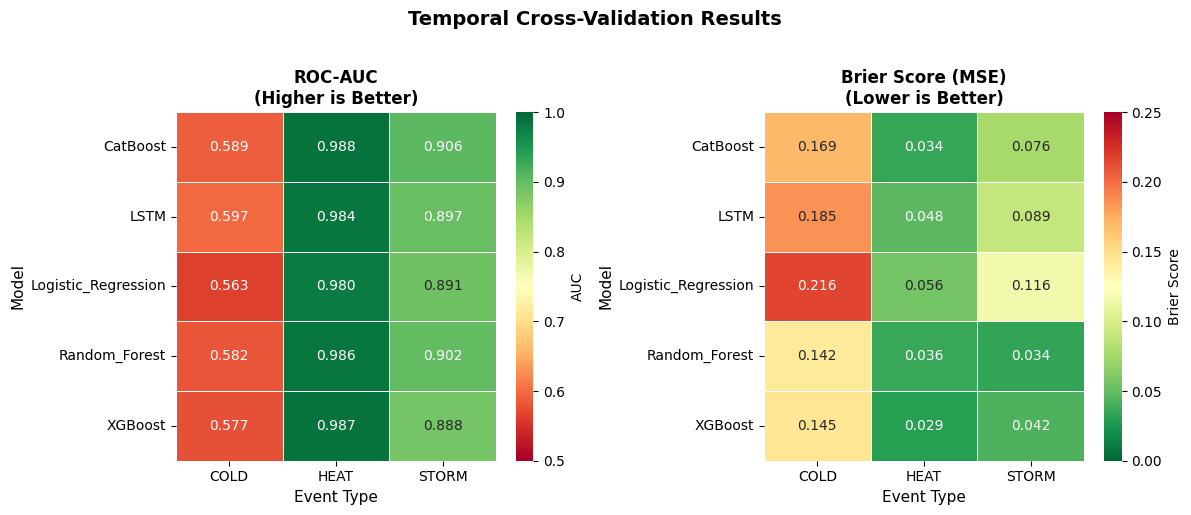


Heatmap saved as 'temporal_cv_heatmap.png'


In [17]:
# ============================================================
# HEATMAP: MODEL PERFORMANCE SUMMARY
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Pivot data for heatmaps
auc_pivot = summary_df.pivot(index='model', columns='target', values='auc_mean')
brier_pivot = summary_df.pivot(index='model', columns='target', values='brier_score_mean')

# AUC Heatmap (higher is better)
sns.heatmap(auc_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0.5, vmax=1.0, ax=axes[0], cbar_kws={'label': 'AUC'},
            linewidths=0.5, linecolor='white')
axes[0].set_title('ROC-AUC\n(Higher is Better)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Event Type', fontsize=11)
axes[0].set_ylabel('Model', fontsize=11)

# Brier Heatmap (lower is better)
sns.heatmap(brier_pivot, annot=True, fmt='.3f', cmap='RdYlGn_r', 
            vmin=0, vmax=0.25, ax=axes[1], cbar_kws={'label': 'Brier Score'},
            linewidths=0.5, linecolor='white')
axes[1].set_title('Brier Score (MSE)\n(Lower is Better)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Event Type', fontsize=11)
axes[1].set_ylabel('Model', fontsize=11)

plt.suptitle('Temporal Cross-Validation Results', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('temporal_cv_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nHeatmap saved as 'temporal_cv_heatmap.png'")

ROC Curves for Last Fold (Fold 4)
  Validation Period: 2020-10-01 to 2020-12-31
  Using stored predictions from training loop


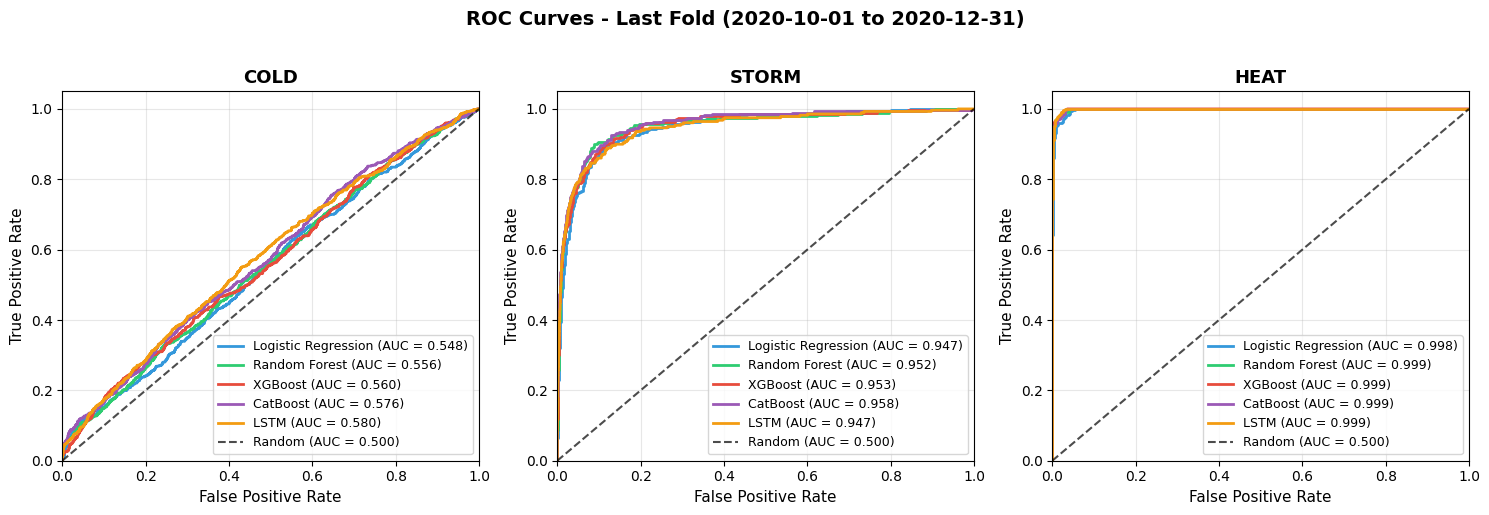


ROC curves saved as 'roc_curves_last_fold.png'


In [18]:
# ============================================================
# ROC CURVES FOR LAST FOLD (OPTIONAL VISUALIZATION)
# ============================================================
# Uses predictions stored during training - no re-training needed!

from sklearn.metrics import roc_curve, auc

# Get last fold info for title
last_fold_idx = temporal_cv.get_n_splits() - 1
train_end, val_start, val_end = temporal_cv.folds[last_fold_idx]

print(f"ROC Curves for Last Fold (Fold {last_fold_idx + 1})")
print(f"  Validation Period: {val_start} to {val_end}")
print("  Using stored predictions from training loop")
print("=" * 70)

# Create figure with subplots for each target
target_names = ['COLD', 'STORM', 'HEAT']
model_names = ['Logistic_Regression', 'Random_Forest', 'XGBoost', 'CatBoost', 'LSTM']
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

fig, axes = plt.subplots(1, len(target_names), figsize=(5 * len(target_names), 5))

for col, target_name in enumerate(target_names):
    ax = axes[col]
    
    # Plot ROC curve for each model using stored predictions
    for model_name, color in zip(model_names, colors):
        try:
            # Get stored predictions from training loop
            y_val, y_pred_proba = last_fold_predictions[target_name][model_name]
            
            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            
            # Plot
            label = f'{model_name.replace("_", " ")} (AUC = {roc_auc:.3f})'
            ax.plot(fpr, tpr, color=color, linewidth=2, label=label)
            
        except KeyError:
            print(f"  Warning: No predictions stored for {model_name} on {target_name}")
        except Exception as e:
            print(f"  Warning: {model_name} failed for {target_name}: {str(e)[:40]}")
    
    # Plot diagonal (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.7, label='Random (AUC = 0.500)')
    
    # Styling
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'{target_name}', fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'ROC Curves - Last Fold ({val_start} to {val_end})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('roc_curves_last_fold.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nROC curves saved as 'roc_curves_last_fold.png'")